In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

%load_ext jupyter_black

## Circular-Linear Regression

In [2]:
from pycircstat2.regression import CLRegression

In [3]:
from pycircstat2 import load_data

df = load_data("B20", source="fisher")
X = df["x"].values
θ = np.deg2rad(df["θ"].values)

data_cl = pd.DataFrame({"X": X, "θ": θ})

# Fit the model
cl_reg_mean = CLRegression(formula="θ ~ X", model_type="mean", data=data_cl, tol=1e-10)
cl_reg_kappa = CLRegression(
    formula="θ ~ X", model_type="kappa", data=data_cl, tol=1e-10
)
beta0 = cl_reg_mean.result["beta"]
gamma0, alpha0 = cl_reg_kappa.result["gamma"], cl_reg_kappa.result["alpha"]

In [4]:
cl_reg_mixed = CLRegression(
    formula="θ ~ X",
    model_type="mixed",
    data=data_cl,
    tol=1e-10,
    beta0=beta0,
    alpha0=alpha0,
    gamma0=gamma0,
)

cl_reg_mixed.summary()


Mixed Circular-Linear Regression

Call:
  CLRegression(model_type='mixed')

Coefficients for Mean Direction (Beta):

      Estimate     Std. Error   t value    Pr(>|t|)    
β_0   -0.00376     nan          nan        nan         

Coefficients for Concentration (Gamma):

      Estimate     Std. Error   t value    Pr(>|t|)    
γ_0   0.04590      nan          nan        nan         

Intercept for Concentration (Alpha):
  Estimate: -0.41402

Summary:
  Mean Direction (mu) in radians:
    mu: 1.91715 (SE: nan)

  Concentration Parameter (kappa):
    kappa: 16.11628 (SE: nan)

Log-Likelihood: 37.81777

Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
p-values are approximated using the normal distribution.



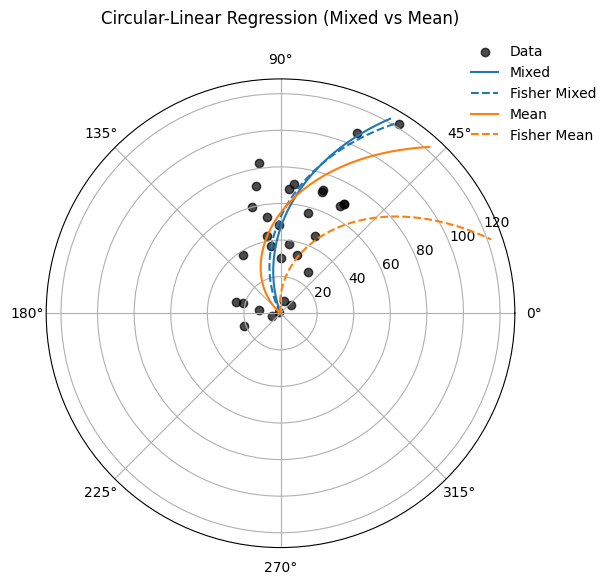

In [5]:
# Compute the mean of X
mean_x = np.mean(X)

# Compute radial deviations from the mean for observed data
radii_data = mean_x + (X - mean_x)

# Compute predicted θ values
# predicted_θ = angmod(cl_model.result["mu"] + 2 * np.arctan(X * cl_model.result["beta"][0]))

predicted_θ = cl_reg_mixed.predict(X[:, None])
X_ = np.linspace(0, X.max(), 100)
fitted_curve_mixed = cl_reg_mixed.predict(X_[:, None])
fitted_curve_mean = cl_reg_mean.predict(X_[:, None])
fitted_curve_fisher_mixed = np.deg2rad(117.1) + 2 * np.arctan(
    X_[:, None] @ np.array([-0.0046])
)
fitted_curve_fisher_mean = np.deg2rad(97.0) + 2 * np.arctan(
    X_[:, None] @ np.array([-0.0066])
)

# Radial position of predicted points: fixed on the mean circle
radii_predicted = mean_x + (X - mean_x)  # Same radial framework as observed data
# Plotting
fig, ax = plt.subplots(
    figsize=(6, 6), subplot_kw={"polar": True}, constrained_layout=True
)

# Plot observed data points
ax.scatter(θ, radii_data, color="black", alpha=0.7, label="Data")

# Plot predicted points on the mean circle
ax.plot(fitted_curve_mixed, X_, color="C0", label="Mixed")
ax.plot(fitted_curve_fisher_mixed, X_, color="C0", label="Fisher Mixed", linestyle="--")

ax.plot(fitted_curve_mean, X_, color="C1", label="Mean")
ax.plot(fitted_curve_fisher_mean, X_, color="C1", label="Fisher Mean", linestyle="--")

# Add labels and legend
ax.set_title("Circular-Linear Regression (Mixed vs Mean)", pad=40)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), frameon=False)

The results from our implementation of the Mixed Circular-Linear model are quite close to those reported in Fisher (1993), though not exactly the same. We have reason to believe that the numbers reported in the book may not be entirely correct, as the results for the mean direction model were significantly different from both our implementation and the results obtained using R/circular.

In [6]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p pycircstat2

Last updated: 2024-12-17 16:57:18CET

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

pycircstat2: 0.1.6

numpy      : 2.2.0
pandas     : 2.2.3
matplotlib : 3.10.0
pycircstat2: 0.1.6

Watermark: 2.5.0

